In [13]:
import matplotlib.pyplot as plt
import matplotlib
from sklearn import svm
from sklearn.model_selection import cross_validate
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_curve, auc
import pandas as pd
import numpy as np
import warnings
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.ensemble import BaggingClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import f1_score
%matplotlib inline

In [2]:
warnings.filterwarnings('ignore')

In [3]:
p_num = 1
original_df = pd.read_csv(r'C:\Users\james\Documents\Hishtalmut_Kamdan\Targil 1 - Data Visualiztion\My - Home Credit Default Risk.csv')
original_df.drop(columns=['Unnamed: 0'], inplace=True)

In [4]:
def get_object_column_names(df):
    types_df = df.dtypes.reset_index()
    cols_list = list(types_df['index'][types_df[0]=='object'])
    return cols_list

In [5]:
def preprocess_data(df):
    # remove NAN values
    df_preprocessed = df.fillna(method='ffill')
    df_preprocessed[df_preprocessed['CNT_CHILDREN'].isnull()] = df_preprocessed[df_preprocessed['CNT_CHILDREN'].isnull()].fillna(0)
    # remove lines with TARGET=2
    target_2_index_list = list(df_preprocessed[df_preprocessed['TARGET']==2].index)
    df_clean_target = df_preprocessed.drop(df_preprocessed.index[target_2_index_list])
    # transform object types to int
    df_dummies = df_clean_target.copy()
    for col in get_object_column_names(df_dummies):
        df_dummies = pd.concat([df_dummies.drop(col,axis=1), pd.get_dummies(df_dummies[col], prefix=col)], axis=1)
    return df_dummies

In [6]:
processed_data = preprocess_data(original_df)
X = processed_data.drop('TARGET', axis=1)
y = processed_data['TARGET']
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

## K-Fold Cross Validation

In [7]:
clf = svm.SVC(kernel='linear', C=1, random_state=0)
scores = cross_validate(clf, X, y, cv=5, scoring='accuracy')
print("Test Score")
print(scores['test_score'])
print("Accuracy: %0.2f (+/- %0.2f)" % (scores['test_score'].mean(), scores['test_score'].std() * 2))

Test Score
[0.575      0.51282051 0.43589744 0.71794872 0.68421053]
Accuracy: 0.59 (+/- 0.21)


## HyperParameters - Grid Search

In [9]:
parameters = {'kernel':(['linear']), 'C':[1, 2]}
svc = svm.SVC(gamma="scale")
clf = GridSearchCV(svc, parameters, cv=5)
clf.fit(X, y)
sorted(clf.cv_results_.keys())

print(clf.best_estimator_
clf.best_params_
clf.best_score_    

0.5846153846153846

## Confusion matrix

In [16]:
clf = RandomForestClassifier(n_estimators=100)
clf_rf = clf.fit(x_train, y_train)
y_pred = clf_rf.predict(x_test)
print(confusion_matrix(y_test, y_pred))
# print("f1 score Random Forest - " + str(f1_score(y_test, y_pred, average='weighted')))

[[23 11]
 [11 20]]


## ROC AUC Curves

### ROC - AUC Create Curves

In [18]:
clf = RandomForestClassifier(n_estimators=100, max_depth=2,random_state=0).fit(x_train,y_train)
y_score = clf.predict_proba(x_test)
n_classes = y_score.shape[1]
print(n_classes)

2


### Compute ROC Area for each Curve

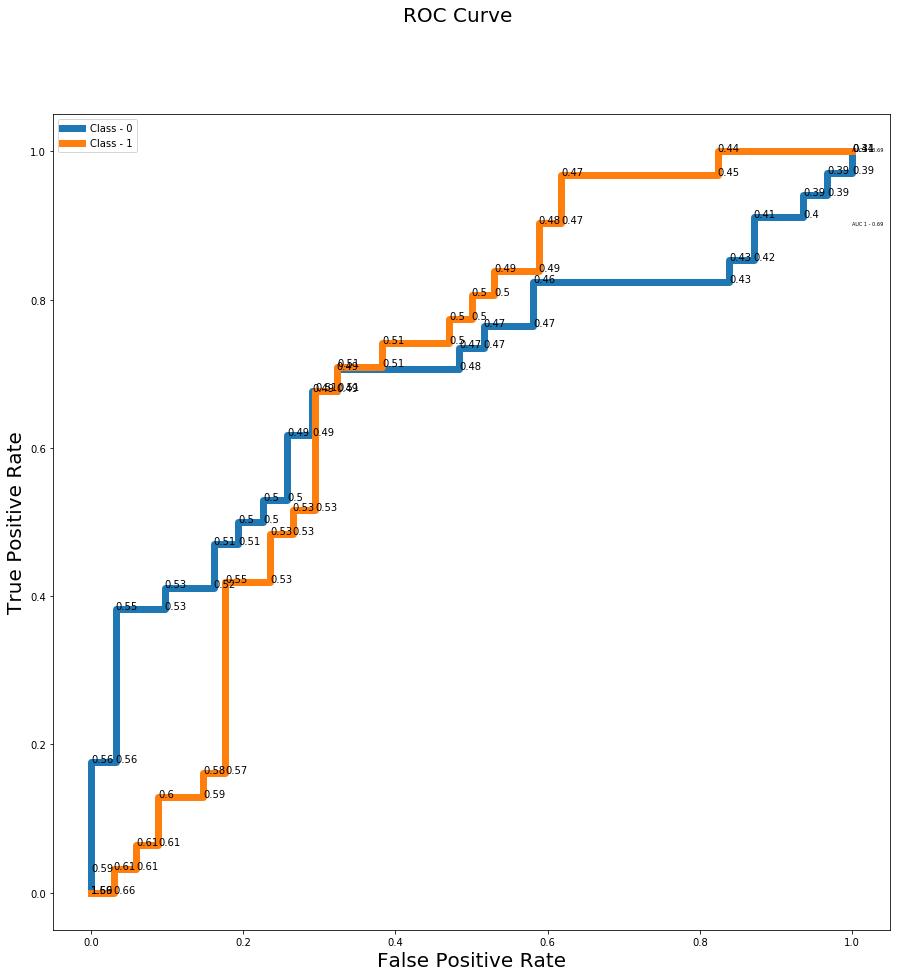

0.6944971537001897


In [26]:
thresholds = list()
for i in range(n_classes):
    temp_test = np.copy(y_test)
    temp_test[temp_test==i]=9
    temp_test[temp_test!=9]=0
    temp_test[temp_test==9]=1
    
    roc_curve_tuple = roc_curve(temp_test, y_score[:, i])
    fpr = roc_curve_tuple[0]
    tpr = roc_curve_tuple[1]
    thresholds = roc_curve_tuple[2]
    roc_auc = auc(fpr, tpr)
    
    plt.figure(p_num)
    plt.plot(fpr,tpr, linewidth=7)
    plt.suptitle("ROC Curve", fontsize=20)
    plt.xlabel("False Positive Rate",fontdict={'fontsize': 20})
    plt.ylabel("True Positive Rate",fontdict={'fontsize': 20})
    plt.legend(['Class - 0','Class - 1'], prop={'size': 10})
    plt.text(1, 1-0.1*i, 'AUC '+ str(i) +' - '+str(round(roc_auc,2)), fontsize=5)
    fig = plt.gcf()
    fig.set_size_inches(15,15,forward=False)
    
    for k in range(len(thresholds)):
        plt.text(float(fpr[k]), float(tpr[k]), str(round(thresholds[k],2)), fontsize=10)

plt.show()
print(roc_auc) 
p_num+=1
selected_thresh = 0.25245606

## Ensembles

### Bagging - Bootstrap Aggregating

In [27]:
clf_rf = RandomForestClassifier(n_estimators=100, max_depth=2,random_state=0)
bagging = BaggingClassifier(clf_rf,max_samples=0.5, max_features=0.5)

print(clf_rf.fit(x_train,y_train).score(x_test,y_test))
print(bagging.fit(x_train,y_train).score(x_test,y_test))

0.6307692307692307
0.6


### Boosting - Ada Boost

In [28]:
clf_boost = AdaBoostClassifier(clf_rf,n_estimators=100)
print(clf_boost.fit(x_train,y_train).score(x_test,y_test))

0.7076923076923077


### Blending

In [33]:
model1 = RandomForestClassifier(n_estimators=200)
model2 = clf_boost

clf_voting = VotingClassifier(estimators=[
        ('RandomForestClassifier', model1), ('AdaBoost', model2)], voting='hard')#'soft'
    

print(clf_voting.fit(x_train,y_train).score(x_test,y_test))

0.7076923076923077
